In [17]:
import sys
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
sys.path.append('..')
from utils.data import get_betamap_paths, load_participant_list

In [18]:
base_dir = '/home/ubuntu/data/learning-habits'
sub_ids = load_participant_list(base_dir)
sub_ids.remove('04')
sub_ids.remove('45')

In [19]:
run = 'test'
reference_model = '/home/ubuntu/data/learning-habits/bids_dataset/derivatives/nilearn/both_modulators_exclude_mask_20250206'
no_duration_model = '/home/ubuntu/data/learning-habits/bids_dataset/derivatives/nilearn/null_durations_20250211'

# Load design matrices

In [20]:
DM_paths , _ = get_betamap_paths(sub_ids, reference_model, run, "sub-{sub_id}_run-{run}_design_matrix.csv")
DM_paths.sort()
DMs = [pd.read_csv(path) for path in DM_paths]

In [21]:
DM_paths_p , _ = get_betamap_paths(sub_ids, no_duration_model, run, "sub-{sub_id}_run-{run}_design_matrix.csv")
DM_paths_p.sort()
DMs_p = [pd.read_csv(path) for path in DM_paths_p]

# Look at include/exclude

In [22]:
DMs[0].columns[:10]

Index(['first_stim_presentation_exclude', 'first_stim_value_rl',
       'first_stim_value_ck', 'first_stim_presentation_include', 'iti',
       'non_response_feedback', 'purple_frame', 'response',
       'second_stim_presentation', 'csf'],
      dtype='object')

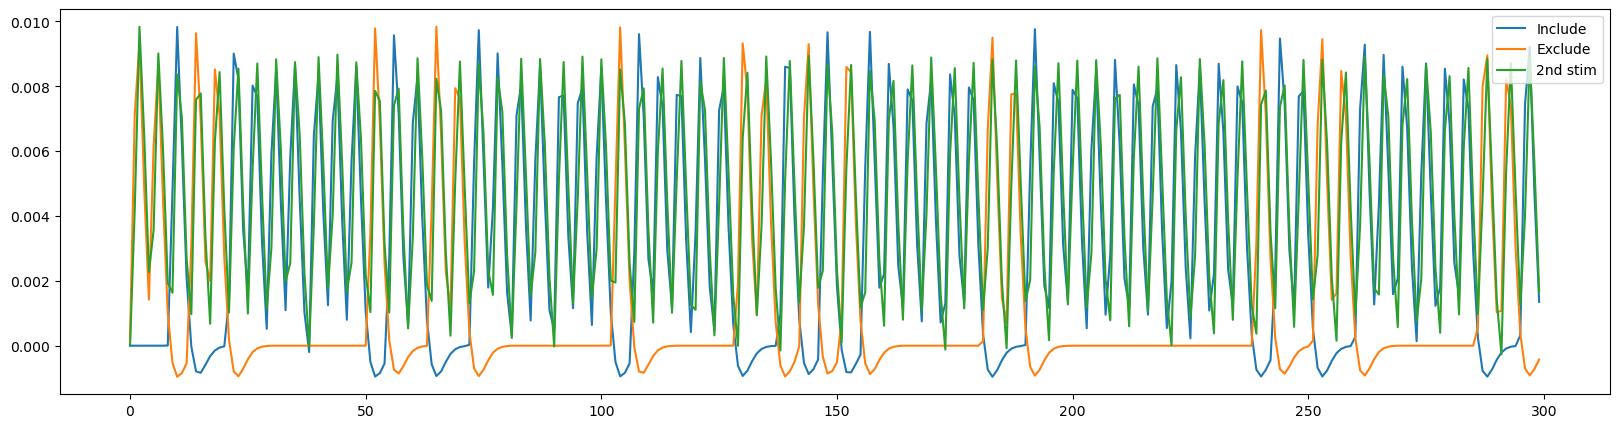

In [36]:
plt.figure(figsize=(20, 5))
plt.plot(DMs_p[0].first_stim_presentation_include[:300], label='Include')
plt.plot(DMs_p[0].first_stim_presentation_exclude[:300], label='Exclude')
plt.plot(DMs_p[0].second_stim_presentation[:300], label='2nd stim')
plt.legend()

In [24]:
# Ensure all design matrices have the same columns in the same order
common_columns = [col for col in DMs[0].columns if col in set.intersection(*(set(dm.columns[:15]) for dm in DMs))]
aligned_DMs = [dm[common_columns] for dm in DMs]

# Compute the average correlation matrix
average_correlation_matrix = np.mean([dm.corr().values for dm in aligned_DMs], axis=0)

# Ensure all design matrices without duration have the same columns in the same order
common_columns_p = [col for col in DMs_p[0].columns if col in set.intersection(*(set(dm.columns[:15]) for dm in DMs_p))]
aligned_DMs_p = [dm[common_columns_p] for dm in DMs_p]

# Compute the average correlation matrix for design matrices without duration
average_correlation_matrix_p = np.mean([dm.corr().values for dm in aligned_DMs_p], axis=0)

In [32]:
# Ensure all design matrices have the same columns in the same order
common_columns = ['first_stim_presentation_include',
                  'first_stim_presentation_exclude',
                  'first_stim_value_rl',
                  'first_stim_value_ck',
                  'second_stim_presentation',
                  'response',
                  'purple_frame',
                  'iti',
                  'white_matter',
                  'csf',
                  'trans_x',
                  'trans_y',
                  'trans_z',
                  'rot_x',
                  'rot_y',
                  'rot_z']

aligned_DMs = [dm[common_columns] for dm in DMs]

# Compute the average correlation matrix
average_correlation_matrix = np.mean([dm.corr().values for dm in aligned_DMs], axis=0)

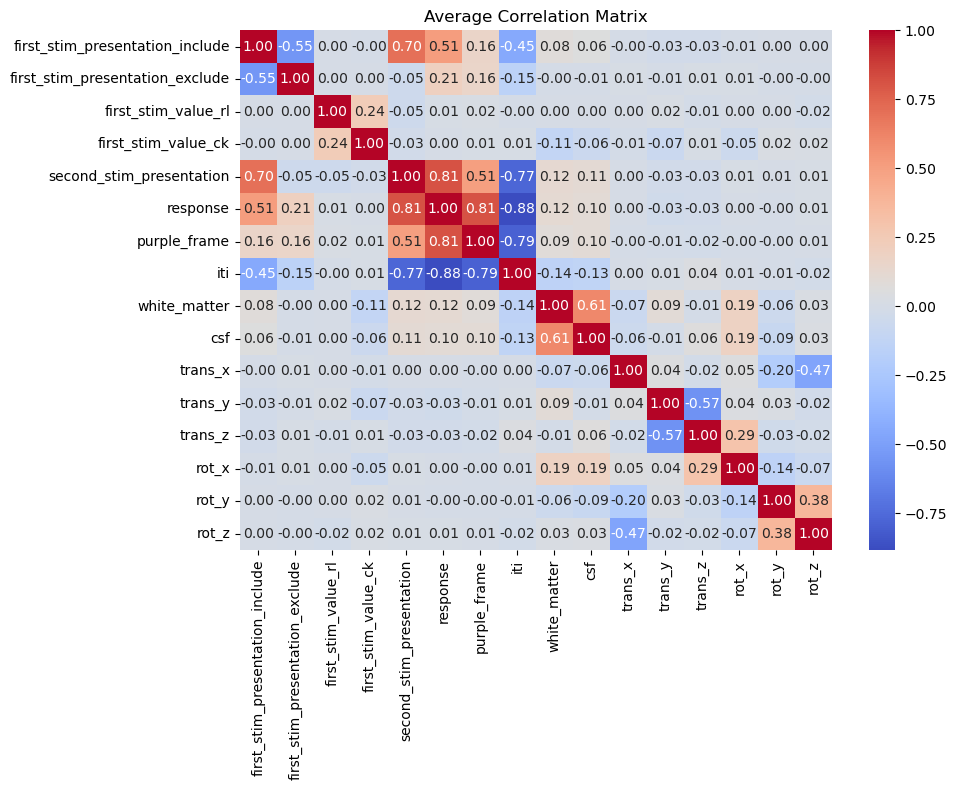

In [33]:
# Plot the difference matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(average_correlation_matrix, xticklabels=common_columns, 
            yticklabels=common_columns, cmap='coolwarm', annot=True, fmt=".2f", ax=ax)
ax.set_title('Average Correlation Matrix')

plt.tight_layout()
plt.show()

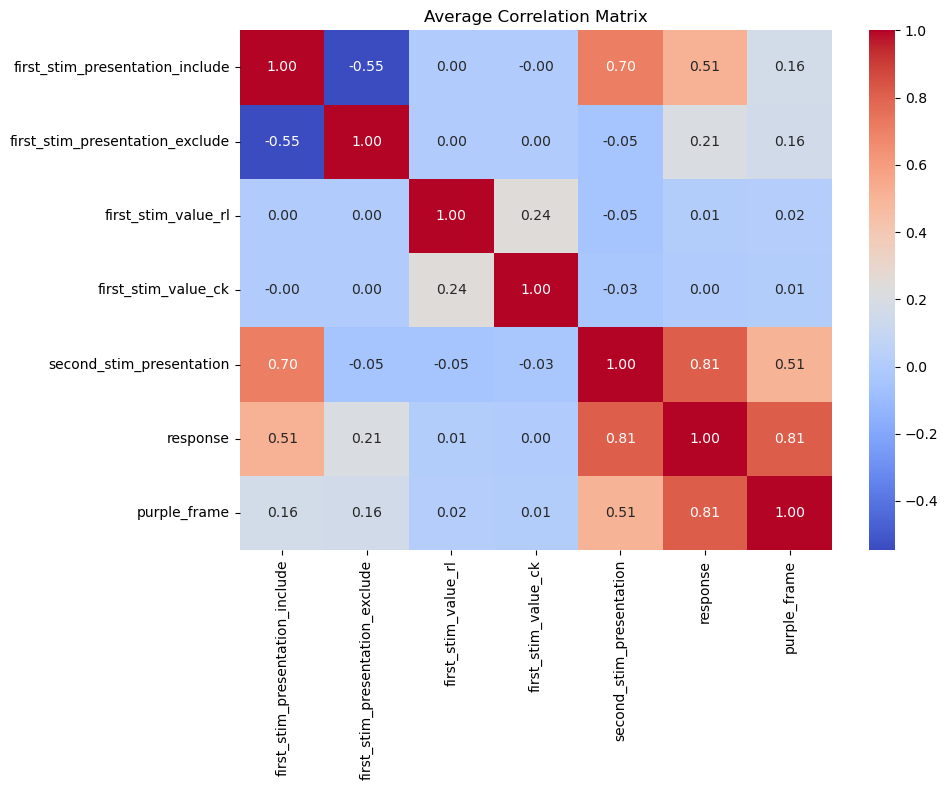

In [34]:
# Plot the difference matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(average_correlation_matrix[:7,:7], xticklabels=common_columns[:7], 
            yticklabels=common_columns[:7], cmap='coolwarm', annot=True, fmt=".2f", ax=ax)
ax.set_title('Average Correlation Matrix')

plt.tight_layout()
plt.show()

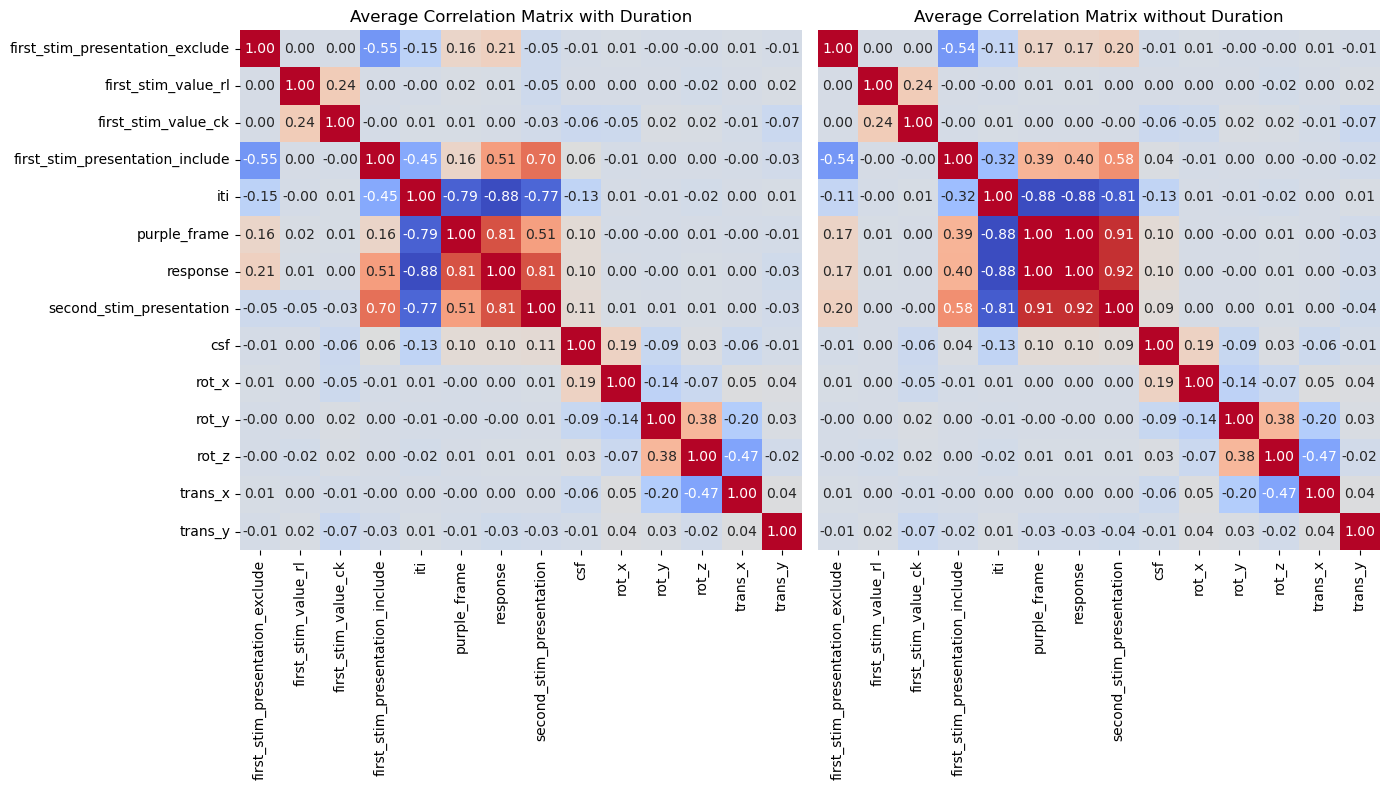

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

sns.heatmap(average_correlation_matrix, xticklabels=common_columns, 
            yticklabels=common_columns, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[0], cbar=False)
axes[0].set_title('Average Correlation Matrix with Duration')

sns.heatmap(average_correlation_matrix_p, xticklabels=common_columns_p,
            yticklabels=False, cmap='coolwarm', annot=True, fmt=".2f", ax=axes[1], cbar=False)
axes[1].set_title('Average Correlation Matrix without Duration')

plt.tight_layout()
plt.show() 

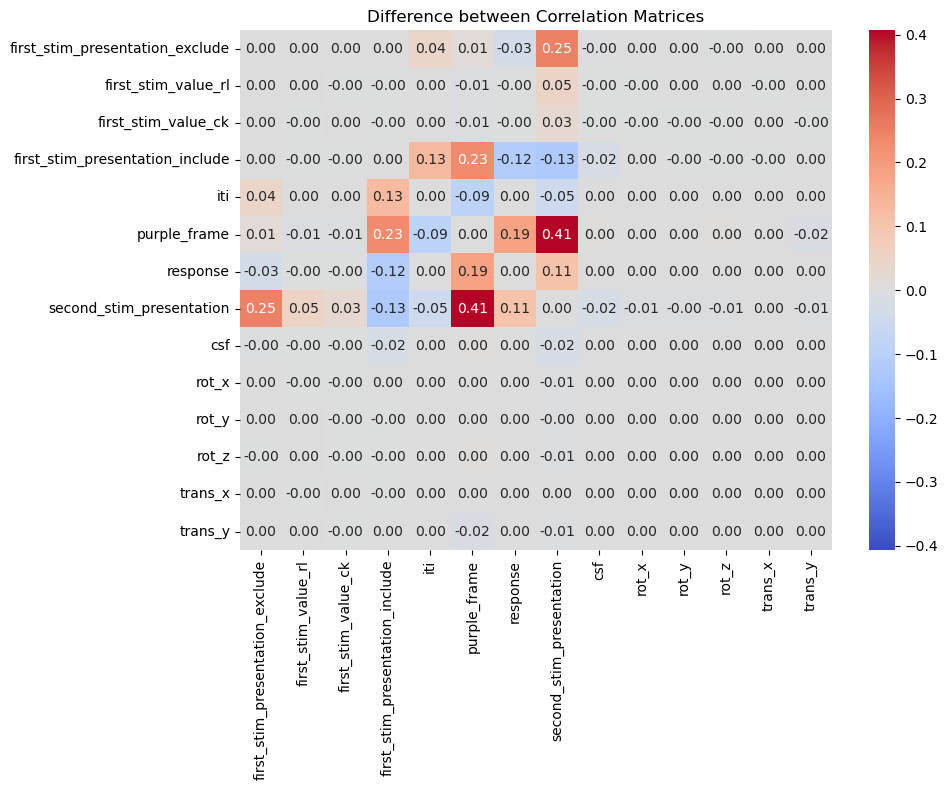

In [26]:
# Compute the difference between the two average correlation matrices
difference_matrix = average_correlation_matrix_p - average_correlation_matrix

# Plot the difference matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(difference_matrix, xticklabels=common_columns, 
            yticklabels=common_columns, cmap='coolwarm', annot=True, fmt=".2f", ax=ax,
            vmin=-np.max(np.abs(difference_matrix)), vmax=np.max(np.abs(difference_matrix)))
ax.set_title('Difference between Correlation Matrices')

plt.tight_layout()
plt.show()

In [27]:
threshold = .6
average_correlation_df = pd.DataFrame(average_correlation_matrix, 
									  columns=aligned_DMs[0].columns, 
									  index=aligned_DMs[0].columns)
high_corr_pairs = np.abs(average_correlation_df).unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[high_corr_pairs != 1.0]  # Remove self-correlations
high_corr_pairs = high_corr_pairs[high_corr_pairs > threshold]

print("Highly correlated columns:", high_corr_pairs)

Highly correlated columns: iti                              response                           0.883004
response                         iti                                0.883004
purple_frame                     response                           0.813226
response                         purple_frame                       0.813226
second_stim_presentation         response                           0.810004
response                         second_stim_presentation           0.810004
iti                              purple_frame                       0.793128
purple_frame                     iti                                0.793128
second_stim_presentation         iti                                0.766718
iti                              second_stim_presentation           0.766718
second_stim_presentation         first_stim_presentation_include    0.704733
first_stim_presentation_include  second_stim_presentation           0.704733
dtype: float64
